In [1]:
!pip3 install transformers

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print("There are %d GPU(s) available." % torch.cuda.device_count())

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# If not...
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [4]:
import random
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import (
    DataLoader,
    Sampler,
    TensorDataset,
    WeightedRandomSampler,
    random_split,
)
from transformers import (
    BertModel,
    BertTokenizer,
    GPT2LMHeadModel,
    GPT2Model,
    GPT2TokenizerFast,
)

zipurl = "https://nyu-mll.github.io/CoLA/cola_public_1.1.zip"
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall("data")
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
!ls data/cola_public/raw

in_domain_dev.tsv  in_domain_train.tsv	out_of_domain_dev.tsv


In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [7]:
def preprocess(df, bs=100, split=True):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    texts = df.iloc[:, 2].to_list()
    labels = torch.from_numpy(df.iloc[:, 0].to_numpy())

    def get_ids(texts):
        input_ids = []
        attention_masks = []

        for sent in texts:
            encoded_dict = tokenizer.encode_plus(
                sent,  # Sentence to encode.
                add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                max_length=64,  # Pad & truncate all sentences.
                pad_to_max_length=True,
                return_attention_mask=True,  # Construct attn. masks.
                return_tensors="pt",  # Return pytorch tensors.
            )
            input_ids.append(encoded_dict["input_ids"])
            attention_masks.append(encoded_dict["attention_mask"])
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        return input_ids, attention_masks

    input_ids, attention_masks = get_ids(texts)
    labels = torch.tensor(labels)

    counts = np.bincount(labels.numpy())
    labels_weights = 1.0 / counts
    weights = labels_weights[labels.numpy()]

    dataset = TensorDataset(input_ids, attention_masks, labels)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    if split:
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        dataloader_train = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        dataloader_val = DataLoader(val_dataset, batch_size=bs, shuffle=True)

        return dataloader_train, dataloader_val
    else:
        return DataLoader(dataset, batch_size=bs, shuffle=True)

In [8]:
df = pd.read_csv(
    "data/cola_public/raw/in_domain_train.tsv",
    sep="\t",
    names=["Grammaticality", "Empty", "Sentence"],
)

dataloader_train, dataloader_val = preprocess(df)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_46831/2756702323.py:26: UserWarning: To copy construct from a tensor, it is recommend

In [9]:
df_test = pd.read_csv(
    "data/cola_public/raw/in_domain_dev.tsv",
    sep="\t",
    names=["Grammaticality", "Empty", "Sentence"],
)

dataloader_test_id = preprocess(df_test, split=False, bs=100)

/tmp/ipykernel_46831/2756702323.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [10]:
df_test = pd.read_csv(
    "data/cola_public/raw/out_of_domain_dev.tsv",
    sep="\t",
    names=["Grammaticality", "Empty", "Sentence"],
)

dataloader_test_od = preprocess(df_test, split=False, bs=100)

/tmp/ipykernel_46831/2756702323.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [11]:
from transformers import AdamW, BertConfig, BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=2,  # The number of output labels--2 for binary classification.
    # You can increase this for multi-class tasks.
    output_attentions=False,  # Whether the model returns attentions weights.
    output_hidden_states=False,  # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,  # args.learning_rate - default is 5e-5, our notebook had 2e-5
    eps=1e-8,  # args.adam_epsilon  - default is 1e-8.
)

In [13]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

total_steps = len(dataloader_train) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # Default value in run_glue.py
    num_training_steps=total_steps,
)

In [14]:
import numpy as np


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
import random

import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

losses_tr = []
losses_ev = []

training_stats = []

for epoch_i in range(0, epochs):
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(dataloader_train):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        out = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels,
        )

        loss = out[0]
        logits = out[1]
        total_train_loss += loss.item()
        losses_tr.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(dataloader_train)
    # losses_tr.append(avg_train_loss)
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in dataloader_val:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            out = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )

        loss = out[0]
        logits = out[1]
        total_eval_loss += loss.item()
        losses_ev.append(loss.item())

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(dataloader_val)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(dataloader_val)
    training_stats.append(
        {
            "epoch": epoch_i + 1,
            "Training Loss": avg_train_loss,
            "Valid. Loss": avg_val_loss,
            "Valid. Accur.": avg_val_accuracy,
        }
    )

  Accuracy: 0.77
  Accuracy: 0.80
  Accuracy: 0.81


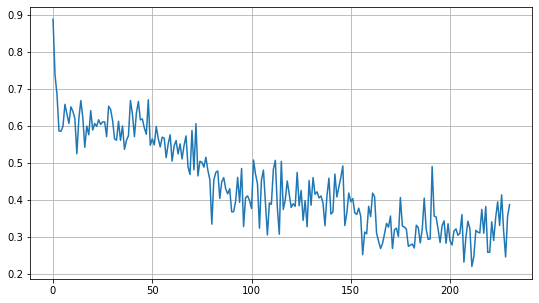

In [16]:
plt.figure(figsize=(9, 5))
plt.plot(losses_tr)
plt.grid()

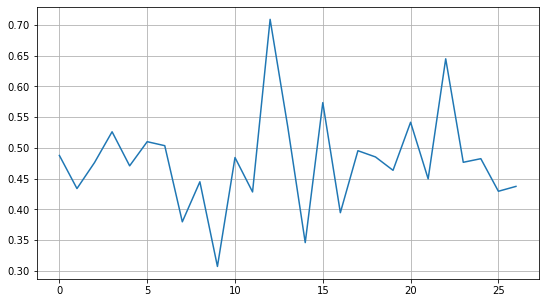

In [17]:
plt.figure(figsize=(9, 5))
plt.plot(losses_ev)
plt.grid()

In [18]:
# model.eval()
def test_model(dataloader):
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            out = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels,
            )

            loss = out[0]
            logits = out[1]
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to("cpu").numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_accuracy = total_eval_accuracy / len(dataloader)
    avg_loss = total_eval_loss / len(dataloader_val)
    print(f"Test accuracy: {round(avg_accuracy, 4)}, test loss: {round(avg_val_loss, 4)}")

In [19]:
test_model(dataloader_test_id)

Test accuracy: 0.8196, test loss: 0.4901


In [20]:
test_model(dataloader_test_od)

Test accuracy: 0.8088, test loss: 0.4901
